# Komplexe Modelle und Deployment

In der abschließenden Veranstaltung unterhalten wir uns über einen kleinen Teilbereich der Konzepte rund um neuronale Netze.
Als Anwendungsfall soll die Klassifizierung von Bildern handschriftlich aufgezeichneter Zahlen (0-9) dienen. So ist es das Ziel dieser Einheit, ein neuronales Netz, in der Folge auch **Multilayer Perceptron (MLP)** genannt, zu designen, zu trainieren und dessen Performance anhand ungesehener Daten zu evaluieren. In einem separaten Pythonfile wird zusätzlich gezeigt, wie Teile der Funktionalität dieses Netzes an REST-Schnittstellen angebunden werden können, um ein Netz dieser Art flexibel einsetzbar zu machen.

### Datensatz
Wie bereits kurz in der Einführung erwähnt, handelt es sich beim verwendeten Datensatz um digitales Bildmaterial handschriftlich verfasster Zahlen, die im Original auf 28x28 Pixel gebannt wurden. In der Welt des maschinellen Lernens und der Bildverarbeitung ist dieses Datenset unter dem Namen [MNIST](http://yann.lecun.com/exdb/mnist/) bekannt und weit verbreitet wenn es um das Design bzw. den Test verschiedenster Bildverarbeitungsalgorithmen geht.
<br>
<br>
<center><img src="../resources/images/mnist.png" style="width: 75%"/></center>
<center>Fig. 1: <a href="https://towardsdatascience.com/improving-accuracy-on-mnist-using-data-augmentation-b5c38eb5a903">towardsdatascience.com</a></center>
<br>
<br>

Um die Verarbeitungszeit zu verkürzen, wird in diesem Beispielnotebook jedoch eine leicht vereinfachte Version dieser Bilddatenbank verwendet. Diese Datenbank ist [direkt in scikit-learn verfügbar](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html) und enthält Bildmaterial, das auf eine Bildgröße von 8x8 skaliert wurde.


### Toolbox
Das Werkzeug zur Erstellung unseres neuronalen Netzes entnehmen wir den Bibliotheken [Keras](https://keras.io/api/) und [TensorFlow](https://www.tensorflow.org/api_docs/python/tf). Seit Version 2.0 von Keras wird diese beliebte Abstraktionsschicht für den Umgang mit Modellen bei der Installation von Tensorflow direkt mitgeliefert. Eine korrekte [Installation](https://www.tensorflow.org/install) der Bibliotheken innerhalb des aktuellen Pythonenvironments, in dem auch dieses Jupyter Notebook gestartet wurde, kann durch das Ausführen folgender Befehlen verifiziert werden:

In [1]:
import keras as k
import tensorflow as tf
print(f'Keras: {k.__version__}')
print(f'TensorFlow: {tf.__version__}')

Keras: 2.6.0
TensorFlow: 2.6.0


### Das neuronale Netz
<br>
<br>
<br>
<br>
<center><img src="../resources/images/neural_network_0.png" style="width: 75%"/></center>
<center>Fig. 2: <a href="https://www.researchgate.net/publication/303875065_ASSESSMENT_OF_ARTIFICIAL_NEURAL_NETWORK_FOR_BATHYMETRY_ESTIMATION_USING_HIGH_RESOLUTION_SATELLITE_IMAGERY_IN_SHALLOW_LAKES_CASE_STUDY_EL_BURULLUS_LAKE">researchgate.net</a></center>
<br>
<br>
Die grundsätzliche Funktionsweise eines neuronalen Netzes, bestehend aus mehreren Schichten sog. Perzeptronen, illustriert Fig. 2. Eine genauere Erklärung dieser Grafik, sowie der Grafik aus Fig. 3, folgt während des Workshops.

<br>
<br>
<center><img src="../resources/images/neural_network_1.png" style="width: 75%"/></center>
<center>Fig. 3: <a href="https://towardsdatascience.com/image-classification-in-10-minutes-with-mnist-dataset-54c35b77a38d">towardsdatascience.com</a></center>



In [2]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline 
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, learning_curve, StratifiedKFold
import os
from keras.models import Sequential
from keras.layers import Dense, Input
from sklearn.datasets import load_digits
import itertools
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

In [3]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    fig = plt.figure(figsize=(10, 10))

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=3, out=None)  
    
    
    thresh = cm.max() / 2.
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    fig.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [4]:
# Simple function that plots loss over epochs and accuracy over epochs (for both train and validation set).
# Also adds a marker for the epoch, where early stopping should be performed if the appropriate index is passed
def plot_learning_curve_over_epochs(history = None, early_stopping = None):
    fig = plt.figure(figsize=(12, 10), dpi=80)
    plt.subplot(2, 1, 1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Loss Curves')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train Loss', 'Validation Loss'], loc='best')
    if early_stopping:
        plt.axvline(x=early_stopping+1, color='r', linestyle='-', label="Early Stopping: "+str(early_stopping+1))
    
    
    plt.subplot(2, 1, 2)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Accuracy Curves')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train Accuracy', 'Validation Accuracy'], loc='best')
    if early_stopping:
        plt.axvline(x=early_stopping+1, color='r', linestyle='-', label="Early Stopping: "+str(early_stopping+1))
    
    plt.show()

### Laden des Datensatzes
Folgender Codeabschnitt kümmert sich um das Laden der Bilddaten (abgespeichert in **X**) und der dazu korrespondierenden Labels (abgelegt in **y**).

Außerdem wird ausgegeben, wieviele Bilder insgesamt im Datensatz vorhanden sind, und dazu zehn Beispielbilder im Notebook festgehalten.

Anzahl der Bilder:	1797

Erste 10 Bilder des Datensatzes:


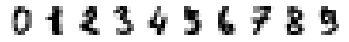

In [41]:
digits = load_digits()
X, y = digits.images, digits.target

print(f"Anzahl der Bilder:\t{len(X)}")

images_to_print = 10
print(f"\nErste {images_to_print} Bilder des Datensatzes:")
for i,image in enumerate(X):
    if i < images_to_print:
        plt.subplot(1, images_to_print, i+1)
        plt.axis('off')
        plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')

### Vorverarbeitung der Daten
Einfache neuronale Netze setzen es voraus, Daten in Form eines Vektors übergeben zu bekommen (vgl. Fig. 2 Input #1 - Input #4). Außerdem kann es für die Verarbeitung von Grauwertbildern ratsam sein, Grauwerte in Prozentzahlen anzugeben.

Darüber hinaus ist es notwendig, die Labels der einzelnen Bilder so zu codieren, dass für jedes Bild ein Label in Form eines One-Hot-Vectors vorliegt. Dieser Umstand ergibt sich aus der Eigenschaft unseres Beispielnetzes, Pseudowahrscheinlichkeiten für die möglichen Klassen eines Bildes (0-9) zu errechnen (vgl. Gaussian Naive Bayes Classifier). Diese Pseudowahrscheinlichkeiten gilt es im letzten Schritt der Klassifizierung, also im Teil der Netzperformanceevaluierung, zu den finalen Prädiktionen des Netzes zu konvertieren.

Abschließend dürfen wir natürlich nicht vergessen, einen Teil unseres Datensatzes (**X_test** und **y_test**) für die eben angesprochene finale Evaluierung der Modellperformance beiseite zu legen.

In [42]:
X.shape

(1797, 8, 8)

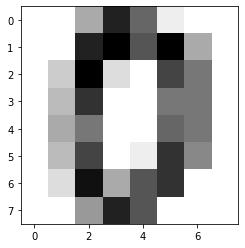

In [43]:
plt.figure()
plt.imshow(X[0], cmap=plt.cm.gray_r, interpolation='nearest')
plt.show()

In [44]:
X = X.reshape(X.shape[0], X.shape[1] * X.shape[2])

In [45]:
X = X / np.amax(X)

In [46]:
X[0]

array([0.    , 0.    , 0.3125, 0.8125, 0.5625, 0.0625, 0.    , 0.    ,
       0.    , 0.    , 0.8125, 0.9375, 0.625 , 0.9375, 0.3125, 0.    ,
       0.    , 0.1875, 0.9375, 0.125 , 0.    , 0.6875, 0.5   , 0.    ,
       0.    , 0.25  , 0.75  , 0.    , 0.    , 0.5   , 0.5   , 0.    ,
       0.    , 0.3125, 0.5   , 0.    , 0.    , 0.5625, 0.5   , 0.    ,
       0.    , 0.25  , 0.6875, 0.    , 0.0625, 0.75  , 0.4375, 0.    ,
       0.    , 0.125 , 0.875 , 0.3125, 0.625 , 0.75  , 0.    , 0.    ,
       0.    , 0.    , 0.375 , 0.8125, 0.625 , 0.    , 0.    , 0.    ])

In [51]:
y

array([0, 1, 2, ..., 8, 9, 8])

In [52]:
set(y)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

In [53]:
y.shape

(1797,)

In [54]:
y = tf.keras.utils.to_categorical(y)

In [55]:
y

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### Konfiguration eines neuronalen Netzes

Nachdem der Schritt der Datenvorverarbeitung nun abgeschlossen ist, kümmern wir uns um die Konfiguration unseres neuronalen Netzes. In unserem Beispiel ist es zwingend erforderlich, folgende Parameter zu setzen:

- Dimensionalität der **Input-Schicht**
- Dimensionalität des **Output-Schicht**
- **Anzahl der verborgenen Schichten** im neuronalen Netz
- Anzahl der **Perzeptronen pro verborgener Schicht**
- Wahl der **Übertragungsfunktion** pro verborgener Schicht und für die Output-Schicht
- Wahl einer **loss function** (zu dt. "Verlustfunktion") und eines sog. **optimizers**, die zur Minimierung des Fehlers verwendet werden.

In [83]:
input_dim = X.shape[1]
output_dim = y.shape[1]

In [84]:
model = Sequential()
model.add(Input(shape=input_dim, name='Input_Layer'))
model.add(Dense(32, activation='relu', name='Hidden_Layer_0'))
model.add(Dense(16, activation='relu', name='Hidden_Layer_1'))
model.add(Dense(output_dim, activation='softmax', name='Output_Layer'))

In [85]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc']
             )

In [86]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Hidden_Layer_0 (Dense)       (None, 32)                2080      
_________________________________________________________________
Hidden_Layer_1 (Dense)       (None, 16)                528       
_________________________________________________________________
Output_Layer (Dense)         (None, 10)                170       
Total params: 2,778
Trainable params: 2,778
Non-trainable params: 0
_________________________________________________________________


### Trainieren des Modells
Wie bereits aus dem letzten Workshop bekannt, startet ein Aufruf der Methode `fit()` eines Modells das Training.
Die Untersuchung des Trainingsfortschritts erfolgt auf Basis der sog. "Learning Curve", welche aus dem Rückgabewert der Methode `fit()`. Diese Kurve kann über die in diesem Notebook eigens dafür definierte Funktion `plot_learning_curve_over_epochs()` gezeichnet werden.

In [87]:
history = model.fit(X_train,
          y_train,
          batch_size=128,
          validation_split=0.3,
          epochs=200,
          verbose=1)

Epoch 1/200
8/8 [==============================] - 0s 15ms/step - loss: 2.3182 - acc: 0.0746 - val_loss: 2.2890 - val_acc: 0.1157
Epoch 2/200
8/8 [==============================] - 0s 3ms/step - loss: 2.2699 - acc: 0.1642 - val_loss: 2.2414 - val_acc: 0.1806
Epoch 3/200
8/8 [==============================] - 0s 3ms/step - loss: 2.2178 - acc: 0.2796 - val_loss: 2.1834 - val_acc: 0.2778
Epoch 4/200
8/8 [==============================] - 0s 3ms/step - loss: 2.1601 - acc: 0.3731 - val_loss: 2.1142 - val_acc: 0.3958
Epoch 5/200
8/8 [==============================] - 0s 3ms/step - loss: 2.0886 - acc: 0.4428 - val_loss: 2.0391 - val_acc: 0.4468
Epoch 6/200
8/8 [==============================] - 0s 3ms/step - loss: 2.0084 - acc: 0.4915 - val_loss: 1.9584 - val_acc: 0.4815
Epoch 7/200
8/8 [==============================] - 0s 3ms/step - loss: 1.9235 - acc: 0.5124 - val_loss: 1.8733 - val_acc: 0.5093
Epoch 8/200
8/8 [==============================] - 0s 3ms/step - loss: 1.8309 - acc: 0.5353 - va

8/8 [==============================] - 0s 3ms/step - loss: 0.1272 - acc: 0.9692 - val_loss: 0.1189 - val_acc: 0.9792
Epoch 65/200
8/8 [==============================] - 0s 3ms/step - loss: 0.1246 - acc: 0.9721 - val_loss: 0.1204 - val_acc: 0.9722
Epoch 66/200
8/8 [==============================] - 0s 3ms/step - loss: 0.1225 - acc: 0.9741 - val_loss: 0.1150 - val_acc: 0.9769
Epoch 67/200
8/8 [==============================] - 0s 3ms/step - loss: 0.1195 - acc: 0.9701 - val_loss: 0.1162 - val_acc: 0.9769
Epoch 68/200
8/8 [==============================] - 0s 3ms/step - loss: 0.1167 - acc: 0.9731 - val_loss: 0.1142 - val_acc: 0.9745
Epoch 69/200
8/8 [==============================] - 0s 3ms/step - loss: 0.1148 - acc: 0.9751 - val_loss: 0.1099 - val_acc: 0.9792
Epoch 70/200
8/8 [==============================] - 0s 3ms/step - loss: 0.1122 - acc: 0.9741 - val_loss: 0.1101 - val_acc: 0.9769
Epoch 71/200
8/8 [==============================] - 0s 3ms/step - loss: 0.1101 - acc: 0.9761 - val_loss

Epoch 127/200
8/8 [==============================] - 0s 3ms/step - loss: 0.0436 - acc: 0.9960 - val_loss: 0.0696 - val_acc: 0.9838
Epoch 128/200
8/8 [==============================] - 0s 3ms/step - loss: 0.0426 - acc: 0.9960 - val_loss: 0.0700 - val_acc: 0.9838
Epoch 129/200
8/8 [==============================] - 0s 3ms/step - loss: 0.0425 - acc: 0.9980 - val_loss: 0.0723 - val_acc: 0.9769
Epoch 130/200
8/8 [==============================] - 0s 3ms/step - loss: 0.0412 - acc: 0.9980 - val_loss: 0.0692 - val_acc: 0.9815
Epoch 131/200
8/8 [==============================] - 0s 3ms/step - loss: 0.0409 - acc: 0.9960 - val_loss: 0.0689 - val_acc: 0.9838
Epoch 132/200
8/8 [==============================] - 0s 3ms/step - loss: 0.0407 - acc: 0.9970 - val_loss: 0.0708 - val_acc: 0.9769
Epoch 133/200
8/8 [==============================] - 0s 3ms/step - loss: 0.0396 - acc: 0.9980 - val_loss: 0.0685 - val_acc: 0.9815
Epoch 134/200
8/8 [==============================] - 0s 3ms/step - loss: 0.0390 - a

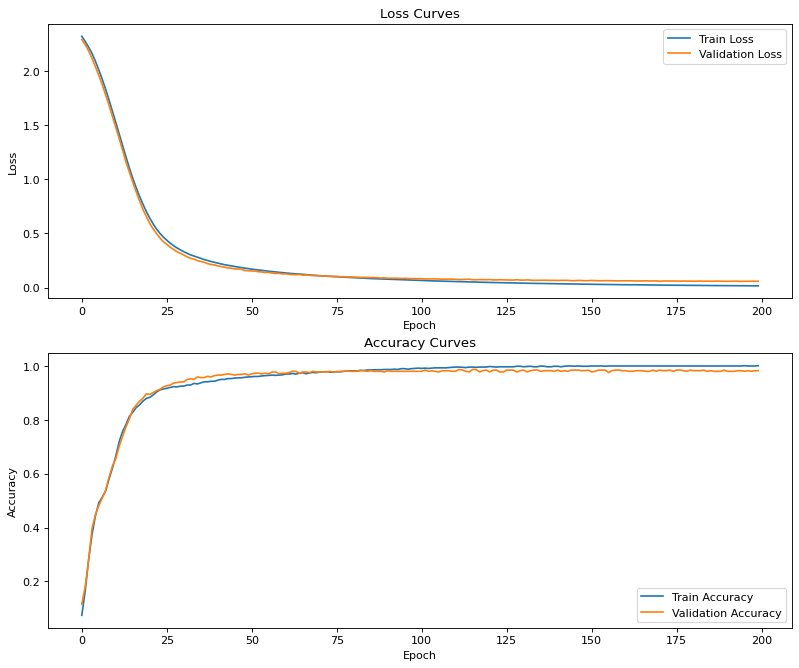

In [88]:
plot_learning_curve_over_epochs(history)

### Evaluierung der Modellperformance
Unser erstes neuronales Netz hat natürlich auch auf ungesehene Daten entsprechend zu performen. Die entsprechenden Untersuchungen werden auf Basis der bewährten Confusion Matrix unternommen, wobei natürlich nur jene Daten herangezogen werden dürfen, die aus dem Trainingsprozess herausgehalten wurden.

In [89]:
y_pred_probabilities = model.predict(X_test)

In [90]:
y_pred = np.argmax(y_pred_probabilities, axis=1)

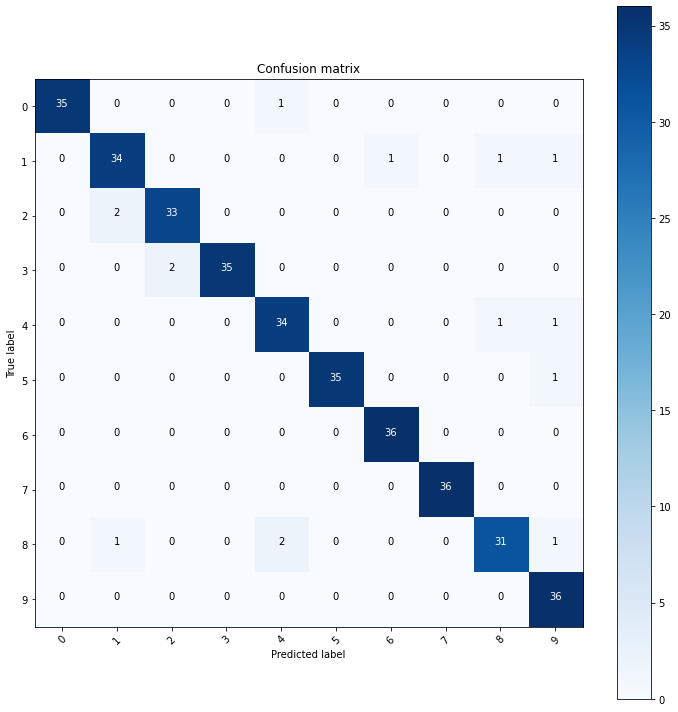

In [91]:
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

plot_confusion_matrix(cm, class_names)

In [92]:
print(classification_report(np.argmax(y_test, axis=1), y_pred))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99        36
           1       0.92      0.92      0.92        37
           2       0.94      0.94      0.94        35
           3       1.00      0.95      0.97        37
           4       0.92      0.94      0.93        36
           5       1.00      0.97      0.99        36
           6       0.97      1.00      0.99        36
           7       1.00      1.00      1.00        36
           8       0.94      0.89      0.91        35
           9       0.90      1.00      0.95        36

    accuracy                           0.96       360
   macro avg       0.96      0.96      0.96       360
weighted avg       0.96      0.96      0.96       360



### Erster Durchlauf: abgeschlossen!

<center><img src="../resources/images/crisp.png" style="width: 35%"/></center>
<center>Fig. 4 <a href="https://mineracaodedados.files.wordpress.com/2012/04/the-crisp-dm-model-the-new-blueprint-for-data-mining-shearer-colin.pdf">CRISP-DM Modell (Shearer 2000)</a></center>

An dieser Stelle sei das CRISP-DM Modell (Fig. 4) erwähnt, das den typischen Ablauf eines Data Science Projekts aufzeigt. Dies Grafik legt uns nun nahe, nach einem ersten Versuch der Modellierung an den Anfang unseres Projektes zurückzugehen, um noch einmal an allen uns zur Verfügung stehenden Stellschrauben zu drehen, um die Modellperformance zu verbessern.

### Exkurs: KFold Cross-Validation und das Serialisieren von Modellen

Der folgende Codeabschnitt zeigt beispielhaft, wie nun eine bestimmte Modellkonfiguration einem genaueren Test per KFold Cross-Validation unterzogen wird. Außerdem zeigt der Aufruf der Methode `save()` eines Kerasmodells, wie ein trainiertes Modell für den späteren Einsatz abgespeichert werden kann.

In [ ]:
from sklearn.model_selection import StratifiedKFold

# Leere Listen für das Abspeichern der Metriken für die Evaluierung der Trainingsperformance
losses = []
val_losses = []
accuracies = []
val_accuracies = []
# Diese Variable dient zur Ermittlung jenes Modells, das den geringsten Validierungsloss zeigt
min_val_loss = 10

# Instanzieren des Objektes zur Implementierung der KFold Cross-Validation
skf = StratifiedKFold(n_splits=10, shuffle=True)

for index, (train_indices, val_indices) in enumerate(skf.split(X_train, y_train.argmax(axis=1))):
    print(f'---------------- Processing fold setting {index}/10 ----------------')
    # Daten für das Training vorbereiten
    X_train_folds, X_val_fold = X_train[train_indices], X_train[val_indices]
    y_train_folds, y_val_fold = y_train[train_indices], y_train[val_indices]
    
    # Modellkonfiguration
    model = Sequential()
    model.add(Input(shape=input_dimension, name='Input_Layer'))
    model.add(Dense(32, activation='relu', name='First_Layer'))
    model.add(Dense(16, activation='relu', name='Second_Layer'))
    model.add(Dense(output_dimension, activation='softmax', name='Output_Layer'))
    model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])
    
    # Training
    history = model.fit(X_train_folds,
                        y_train_folds,
                        validation_data=(X_val_fold, y_val_fold),
                        batch_size=350,
                        epochs=200,
                        verbose=0)
    
    
    # Statistiken für die Evaluierung des Trainingsfortschritts speichern bzw. ausgeben
    final_loss = history.history['loss'][-1]
    losses.append(final_loss)
    final_val_loss = history.history['val_loss'][-1]
    val_losses.append(final_val_loss)
    final_acc = history.history['acc'][-1]
    accuracies.append(final_acc)
    final_val_acc = history.history['val_acc'][-1]
    val_accuracies.append(final_val_acc)
    print(f'Train Loss / Validation Loss:\t\t{final_loss:.3f} / {final_val_loss:.3f}')
    print(f'Train Accuracy / Validation Accuracy:\t{final_acc:.3f} / {final_val_acc:.3f}')
    
    # Das beste Modell (gemessen an der Metrik Validation Loss) für später abspeichern
    if final_val_loss < min_val_loss:
        min_val_loss = final_val_loss
        best_model_index = index
        model.save('digits_classifier.h5')
        

print(f'\n---------- Saved Model from fold setting {best_model_index} to disk. ----------')

### Laden serialisierter Modelle
Die Funktion [load_model()](https://www.tensorflow.org/guide/keras/save_and_serialize) erlaubt es uns, zuvor serialisierte Modell zu reaktivieren. Der folgende Codeabschnitt zeigt das Laden des besten Modells der Cross-Validation, und führt im Anschluss die Evaluierung der Testdaten durch:

In [ ]:
model_from_disk = k.models.load_model('digits_classifier.h5')

In [ ]:
y_pred_probabilities = model_from_disk.predict(X_test)

In [ ]:
y_pred = np.argmax(y_pred_probabilities, axis=1)

In [ ]:
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred)

class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

plot_confusion_matrix(cm, class_names)

In [ ]:
print(classification_report(np.argmax(y_test, axis=1), y_pred))